# General Network Visualization

In [169]:
## imports and configs
import os
import torch
import torchvision
import numpy as np
import random
from matplotlib import pyplot as plt
import torchvision.transforms as T
from PIL import Image
from scipy.ndimage.filters import gaussian_filter1d

PROJECT_ROOT = f"{os.path.expanduser('~')}/project/AIAA5030_Data_Mining_Group13_Visualization"
DATA_ROOT = f"{PROJECT_ROOT}/data"

SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


/tmp/ipykernel_2457429/4245157461.py:10: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


## Load Pretrained Model

In [170]:
# Download and load the pretrained SqueezeNet model.
model = torchvision.models.squeezenet1_1(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

/hpc2hdd/home/xli026/miniforge3/envs/dmv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hpc2hdd/home/xli026/miniforge3/envs/dmv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Load Images

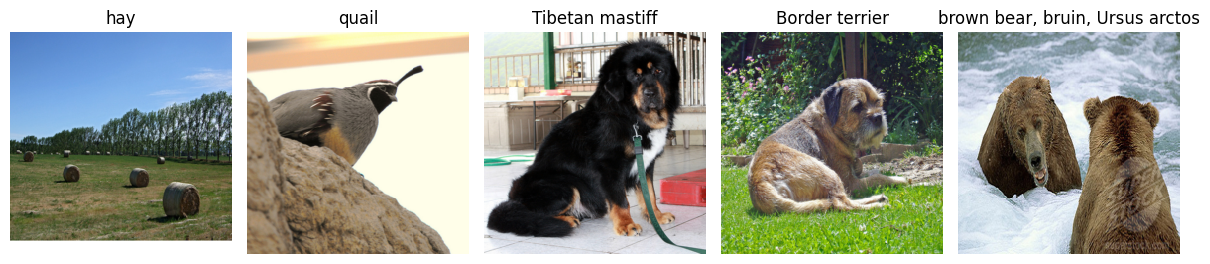

In [171]:
def load_imagenet_val(num=None):
    """Load a handful of validation images from ImageNet.

    Inputs:
    - num: Number of images to load (max of 25)

    Returns:
    - X: numpy array with shape [num, 224, 224, 3]
    - y: numpy array of integer image labels, shape [num]
    - class_names: dict mapping integer label to class name
    """
    imagenet_fn = os.path.join(
        DATA_ROOT, "imagenet_val_25.npz"
    )
    np_load_old = np.load
    np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)
    f = np.load(imagenet_fn)
    np.load = np_load_old
    X = f["X"]
    y = f["y"]
    class_names = f["label_map"].item()
    if num is not None:
        X = X[:num]
        y = y[:num]
    return X, y, class_names

X, y, class_names = load_imagenet_val(num=5)
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis("off")
plt.gcf().tight_layout()

## Saliency Maps [1]
We can use saliency maps to tell which part of the image influenced the classification decision made by the network.

A **saliency map** tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape `(3, H, W)` then this gradient will also have shape `(3, H, W)`; for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape `(H, W)` and all entries are nonnegative.

[1] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

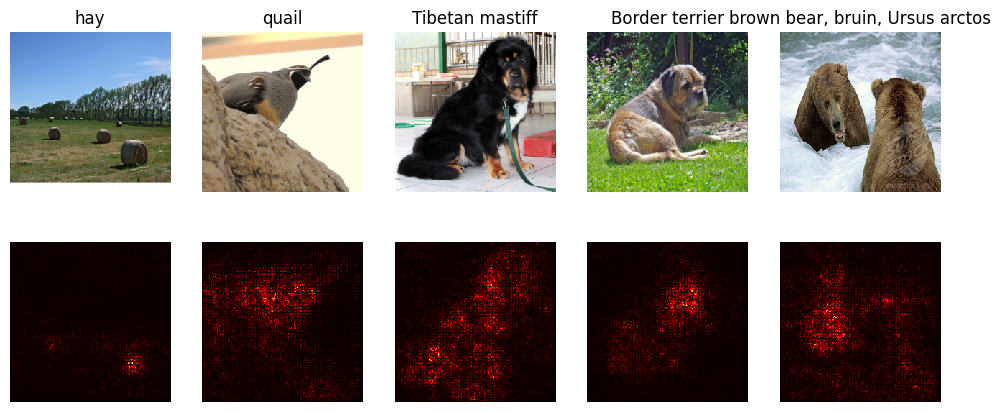

In [172]:
def preprocess(img, size=224):
    transform = T.Compose(
        [
            T.Resize(size),
            T.ToTensor(),
            T.Normalize(mean=SQUEEZENET_MEAN.tolist(), std=SQUEEZENET_STD.tolist()),
            T.Lambda(lambda x: x[None]),
        ]
    )
    return transform(img)

def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()

    # Make input tensor require gradient
    X.requires_grad_()

    saliency = None

    correct_class_score = model(X).gather(1, y.view(-1, 1)).squeeze()
    loss = correct_class_score.sum()
    loss.backward()

    saliency = X.grad.data.abs()
    saliency, _ = saliency.max(dim=1)

    return saliency


def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis("off")
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis("off")
        plt.gcf().set_size_inches(12, 5)
    plt.show()


show_saliency_maps(X, y)

## Fooling Images
We can perturb an input image so that it appears the same to humans but will be misclassified by the pretrained network.

We can also use image gradients to generate "fooling images" as discussed in [2]. Given an image and a target class, we can perform gradient **ascent** over the image to maximize the target class, stopping when the network classifies the image as the target class. Implement the following function to generate fooling images.

[2] Szegedy et al, "Intriguing properties of neural networks", ICLR 2014

In [173]:
def make_fooling_image(X, target_y, model):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image; Tensor of shape (1, 3, 224, 224)
    - target_y: An integer in the range [0, 1000)
    - model: A pretrained CNN

    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    # Initialize our fooling image to the input image, and make it require gradient
    X_fooling = X.clone()
    X_fooling = X_fooling.requires_grad_()

    learning_rate = 1

    step = 0
    while True:
        # Compute model predictions
        pred_y = model(X_fooling)

        if pred_y.max(dim=1)[1] == target_y:
            # If predicted correctly
            break
        
        # Loss is just the target score
        loss = pred_y[0, target_y]
        loss.backward()

        # Gradient ascent with the normalized gradient step, then zero out grad
        X_fooling.data += learning_rate * X_fooling.grad / X_fooling.grad.norm()
        X_fooling.grad.zero_()

    return X_fooling

In [174]:
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print(s)
    print(y)
    print(s.gather(1, y.view(-1, 1)).squeeze())


gather_example()

tensor([[ 0.4189, -1.5773, -1.1896,  2.0279, -0.2192],
        [ 0.9935, -1.3720,  0.0283, -0.2982,  0.4069],
        [-0.2708,  1.2129, -1.7688, -0.8551,  0.4426],
        [-0.1641,  1.1513, -0.3926,  0.4798,  0.3778]])
tensor([1, 2, 1, 3])
tensor([-1.5773,  0.0283,  1.2129,  0.4798])


In [175]:
idx = 0
target_y = 6

X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_fooling = make_fooling_image(X_tensor[idx : idx + 1], target_y, model)

scores = model(X_fooling)
assert scores.max(dim=1)[1].item() == target_y

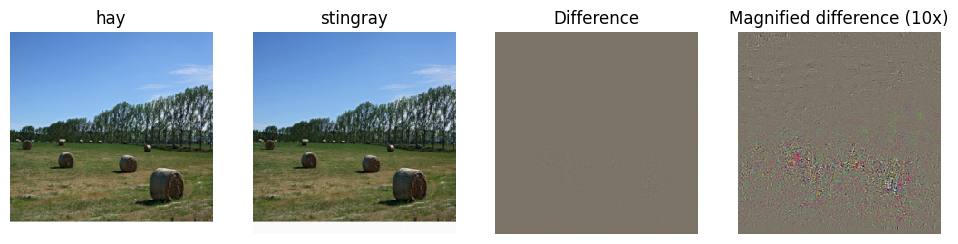

In [176]:
def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def deprocess(img, should_rescale=True):
    transform = T.Compose(
        [
            T.Lambda(lambda x: x[0]),
            T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
            T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
            T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
            T.ToPILImage(),
        ]
    )
    return transform(img)

X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis("off")

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title("Difference")
plt.axis("off")

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title("Magnified difference (10x)")
plt.axis("off")

plt.gcf().set_size_inches(12, 5)
plt.show()

## Class Visualization

We can synthesize an image to maximize the classification score of a particular class; this can give us some sense of what the network is looking for when it classifies images of that class.

In [177]:
def class_visualization_update_step(img, model, target_y, l2_reg, learning_rate):
    scores = model(img)
    target_score = scores[0, target_y]
    R_I = l2_reg * torch.sum(img * img)
    objective = target_score - R_I
    objective.backward()
    grad = img.grad.data
    img.data += learning_rate * grad / torch.norm(grad)
    img.grad.data.zero_()

def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.

    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes

    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

def create_class_visualization(target_y, model, dtype, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.

    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations

    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)
    l2_reg = kwargs.pop("l2_reg", 1e-3)
    learning_rate = kwargs.pop("learning_rate", 25)
    num_iterations = kwargs.pop("num_iterations", 100)
    blur_every = kwargs.pop("blur_every", 10)
    max_jitter = kwargs.pop("max_jitter", 16)
    show_every = kwargs.pop("show_every", 25)

    # Randomly initialize the image as a PyTorch Tensor, and make it requires gradient.
    img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype).requires_grad_()

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.data.copy_(jitter(img.data, ox, oy))
        class_visualization_update_step(img, model, target_y, l2_reg, learning_rate)
        # Undo the random jitter
        img.data.copy_(jitter(img.data, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img.data[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img.data, sigma=0.5)

        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.data.clone().cpu()))
            class_name = class_names[target_y]
            plt.title("%s\nIteration %d / %d" % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis("off")
            plt.show()

    return deprocess(img.data.cpu())

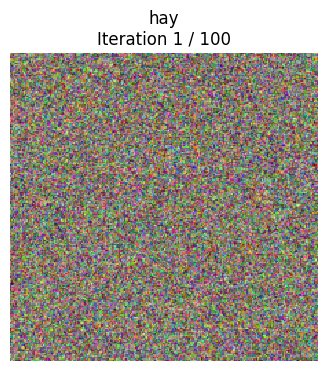

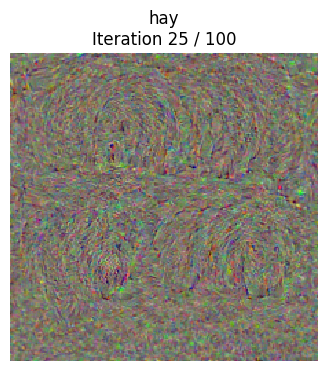

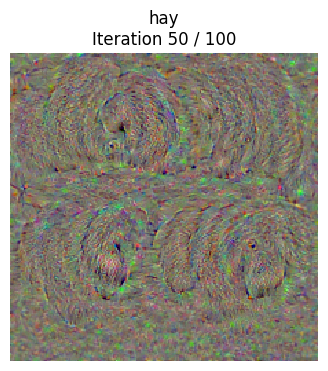

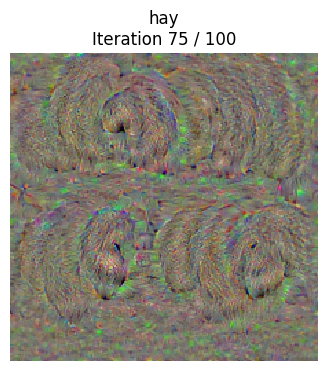

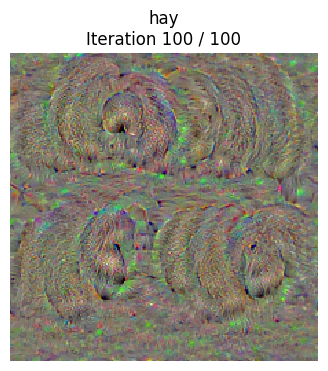

In [ ]:
dtype = torch.FloatTensor
model.type(dtype)

target_y = 958 # hay
# target_y = 6 # Stingray
# target_y = 76  # Tarantula
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
out = create_class_visualization(target_y, model, dtype)